# Imports

In [1]:
import numpy as np
from scipy import stats
import random

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# import library
%run lib.ipynb

# Generate data (yulesimon)

In [2]:
from scipy.stats import yulesimon

def sample_yulesimon(alpha, size):
    return yulesimon.rvs(alpha, loc=0, size=size)

def next_alpha(min_alpha=2.0, max_alpha=3.0):
    alpha = np.random.uniform(low=min_alpha, high=max_alpha, size=1)[0]
    return alpha

# generate data (yulesimon)
def generate_data_yulesimon(N, M, density=False):
    H, alphas = generate_data(N=N, M=M, nextConfig=next_alpha, sample=sample_yulesimon)

    # split train/test
    # (use train_test_split so the shape of the train/test data will be the same)
    H_train, H_test, y_train, y_test = train_test_split(H, alphas, test_size=0.25)
    
    return H_train, y_train, H_test, y_test

# Experiments

In [3]:
N = 10000

In [4]:
def Yulesimon_Experiment(X_train, y_train, X_test, y_test):

    start_time = time.time()
    dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test)
    train_time = round(time.time() - start_time)

    # debug print
    loss = np.min(history['loss'])
    val_loss = np.min(history['val_loss'])
    print(f'sqrt-mse: {sqrt_mse:.4f}', end=', ')
    #print(f'loss: {loss:.4f}', end=', ')
    #print(f'val_loss: {val_loss:.4f}', end=', ')
    print(f'train-time: {round(train_time)} sec.')

    trial_out = {
        'model': dnn_model,
        'history': history,
        'y-test': y_test,
        'y-pred': y_pred,
        'sqrt-mse': sqrt_mse,
        'train-time': train_time
    }

    return trial_out

## Experiment 1 - log vs. exact training
Run an experiment to show that using the log function improves something, either accuracy or learning rate, or both.
Use fixed setting, e.g, YS, samples = 256 or 512.
In this experiment use the LOG(1+X) function.

In [5]:
def experiment_1():
    
    trials_out = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'C': [], 
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [256, 512, 1024, 2048, 4096, 8192]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_yulesimon(N=N, M=M)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        for apply_log_scale in [True, False]:
            
            if apply_log_scale:
                X_train = log_scale(X_train)
                X_test = log_scale(X_test)
                print(f'training (log-scale={apply_log_scale}) ... ', end='')
            else:
                print(f'training (exact-values) ... ', end='')
            
            trial_out = Yulesimon_Experiment(X_train, y_train, X_test, y_test)
            
            trial_out['M'] = M
            trial_out['m'] = m
            
            trials_out.append(trial_out)
            
            sqrt_mse = trial_out['sqrt-mse']
            train_time = trial_out['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(apply_log_scale)
            d['C'].append(0)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials_out, df

trials_out_1, df_1 = experiment_1()


generating dataset (M=256) ... train input.shape: (7500, 2364)
training (log-scale=True) ... sqrt-mse: 0.2042, train-time: 46 sec.
training (exact-values) ... sqrt-mse: 0.2012, train-time: 45 sec.

generating dataset (M=512) ... train input.shape: (7500, 1173)
training (log-scale=True) ... sqrt-mse: 0.1686, train-time: 34 sec.
training (exact-values) ... sqrt-mse: 0.1717, train-time: 37 sec.

generating dataset (M=1024) ... train input.shape: (7500, 2529)
training (log-scale=True) ... sqrt-mse: 0.1373, train-time: 54 sec.
training (exact-values) ... sqrt-mse: 0.1370, train-time: 49 sec.

generating dataset (M=2048) ... train input.shape: (7500, 4959)
training (log-scale=True) ... sqrt-mse: 0.1076, train-time: 86 sec.
training (exact-values) ... sqrt-mse: 0.1078, train-time: 79 sec.

generating dataset (M=4096) ... train input.shape: (7500, 3402)
training (log-scale=True) ... sqrt-mse: 0.0835, train-time: 95 sec.
training (exact-values) ... sqrt-mse: 0.0805, train-time: 113 sec.

gener

,M,m,log-scale,C,sqrt-mse,train-time (sec.)
0,256,2364,True,0,0.2042,46
1,256,2364,False,0,0.2012,45
2,512,1173,True,0,0.1686,34
3,512,1173,False,0,0.1717,37
4,1024,2529,True,0,0.1373,54
5,1024,2529,False,0,0.1370,49
6,2048,4959,True,0,0.1076,86
7,2048,4959,False,0,0.1078,79
8,4096,3402,True,0,0.0835,95
9,4096,3402,False,0,0.0805,113


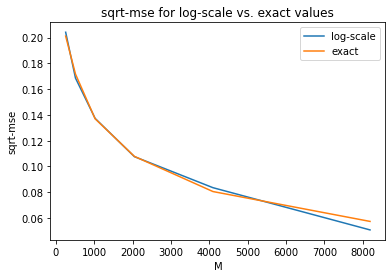

In [6]:
# plot sqrt-mse for log-scale vs. exact
def plot_log_scale_vs_exact(df):
    M_values = df.loc[df['log-scale'] == True][['M']].values
    sqrt_mse_log_scale = df.loc[df['log-scale'] == True][['sqrt-mse']].values
    sqrt_mse_exact = df.loc[df['log-scale'] == False][['sqrt-mse']].values
    _ = plt.plot(M_values, sqrt_mse_log_scale, label='log-scale')
    _ = plt.plot(M_values, sqrt_mse_exact, label='exact')
    plt.title('sqrt-mse for log-scale vs. exact values')
    plt.xlabel('M')
    plt.ylabel('sqrt-mse')
    _ = plt.legend()

plot_log_scale_vs_exact(df_1)
df_1

## Experiment 2 - log shift experiment
Run an experiment to see which C is better if using the function LOG(1+C)
Try, e.g., C = 0.2, 0.5, 1, 2,

In [7]:
def experiment_2():
    
    trials_out = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'C': [], 
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [256, 512, 1024, 2048]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_yulesimon(N=N, M=M)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        apply_log_scale = True
        
        for C in [0.0, 0.2, 0.5, 1.0, 2.0]:

            X_train = log_scale(X_train, C=C)
            X_test = log_scale(X_test, C=C)
            print(f'training (log-scale={apply_log_scale}, C={C} ) ... ', end='')
            
            trial_out = Yulesimon_Experiment(X_train, y_train, X_test, y_test)
            
            trial_out['M'] = M
            trial_out['m'] = m
            
            trials_out.append(trial_out)
            
            sqrt_mse = trial_out['sqrt-mse']
            train_time = trial_out['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(True)
            d['C'].append(C)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials_out, df

trials_out_2, df_2 = experiment_2()


generating dataset (M=256) ... train input.shape: (7500, 2437)
training (log-scale=True, C=0.0 ) ... sqrt-mse: 0.2030, train-time: 41 sec.
training (log-scale=True, C=0.2 ) ... sqrt-mse: 0.2104, train-time: 40 sec.
training (log-scale=True, C=0.5 ) ... sqrt-mse: 0.3930, train-time: 39 sec.
training (log-scale=True, C=1.0 ) ... sqrt-mse: 0.3834, train-time: 39 sec.
training (log-scale=True, C=2.0 ) ... sqrt-mse: 0.6008, train-time: 39 sec.

generating dataset (M=512) ... train input.shape: (7500, 3896)
training (log-scale=True, C=0.0 ) ... sqrt-mse: 0.1734, train-time: 57 sec.
training (log-scale=True, C=0.2 ) ... sqrt-mse: 0.1833, train-time: 58 sec.
training (log-scale=True, C=0.5 ) ... sqrt-mse: 0.2482, train-time: 82 sec.
training (log-scale=True, C=1.0 ) ... sqrt-mse: 0.3654, train-time: 54 sec.
training (log-scale=True, C=2.0 ) ... sqrt-mse: 0.3567, train-time: 53 sec.

generating dataset (M=1024) ... train input.shape: (7500, 1818)
training (log-scale=True, C=0.0 ) ... sqrt-mse:

,M,m,log-scale,C,sqrt-mse,train-time (sec.)
0,256,2437,True,0.0,0.2030,41
1,256,2437,True,0.2,0.2104,40
2,256,2437,True,0.5,0.3930,39
3,256,2437,True,1.0,0.3834,39
4,256,2437,True,2.0,0.6008,39
5,512,3896,True,0.0,0.1734,57
6,512,3896,True,0.2,0.1833,58
7,512,3896,True,0.5,0.2482,82
8,512,3896,True,1.0,0.3654,54
9,512,3896,True,2.0,0.3567,53


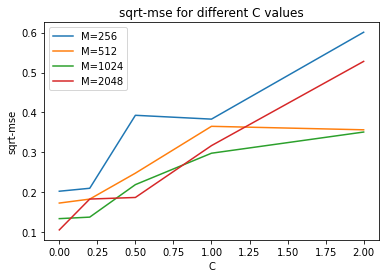

In [8]:
def plot_sqrt_mse_vs_C2(df, M_values):
    
    C_values = df.loc[df['M'] == M_values[0]][['C']].values
    for M in M_values:
        sqrt_mse_for_M = df.loc[df['M'] == M][['sqrt-mse']].values
        _ = plt.plot(C_values, sqrt_mse_for_M, label=f'M={M}')
        plt.xlabel('C')
        plt.ylabel('sqrt-mse')
    plt.title('sqrt-mse for different C values')
    _ = plt.legend()

plot_sqrt_mse_vs_C2(df_2, [256, 512, 1024, 2048])
df_2

## Experiment 3 - bias experiment
Same experiment as usual, but make sure the prediction is unbiased. Average difference should be close to zero

In [9]:
def test_bias(trials, df):
    d = {
        'M': [], 
        'm': [], 
        'sqrt-mse': [],
        'Bias': [],
    }

    for i in range(len(trials)):
        d['M'].append(trials[i]['M'])
        d['m'].append(trials[i]['m'])
        y_test = np.round(trials[i]['y-test'], decimals=2)
        y_pred = np.round(trials[i]['y-pred'], decimals=2)
        avg_diff = np.average(y_test - y_pred)
        d['Bias'].append(np.round(avg_diff, decimals=4))
        d['sqrt-mse'].append(np.round(trials[i]['sqrt-mse'], decimals=4))

    df = pd.DataFrame(data=d)
    return df

df_bias_1 = test_bias(trials=trials_out_1, df=df_1)
df_bias_1

,M,m,sqrt-mse,Bias
0,256,2364,0.2042,-0.0131
1,256,2364,0.2012,-0.0109
2,512,1173,0.1686,0.0121
3,512,1173,0.1717,0.0226
4,1024,2529,0.1373,-0.0089
5,1024,2529,0.1370,-0.0146
6,2048,4959,0.1076,-0.0166
7,2048,4959,0.1078,0.0148
8,4096,3402,0.0835,0.0070
9,4096,3402,0.0805,-0.0023
